# A/B Test Analysis: Single-Page Checkout Redesign

### How Rigorous Experimentation Saved \$25,000 by Catching a Novelty Effect

---

| Detail | Value |
|:---|:---|
| **Experiment** | Single-page checkout vs. multi-step checkout (control) |
| **Duration** | 21 days (Sep 2–22, 2024) |
| **Traffic** | ~76,000 sessions across ~55,000 unique users |
| **Primary KPI** | Session-level conversion rate (CVR) |
| **Decision** | **DO NOT SHIP** |

---

## Executive Summary

The Product team hypothesized that consolidating the multi-step checkout into a **single-page layout** would reduce friction and lift conversion rates. A 21-day, user-level randomized experiment (50/50 split) was designed to evaluate the change with statistical rigor.

**The result: the redesign showed no statistically significant improvement** (p = 0.1853, 95% CI crosses zero). More importantly, the temporal analysis uncovered a **severe novelty effect**, the treatment showed a promising +0.33 pp lift in Week 1 that completely **evaporated to −0.02 pp by Week 3**.
> **Had the results been "peeked" at early and the feature shipped after Week 1, the business would have spent $25,000 implementing a solution with zero sustained value.** By adhering to a pre-registered 21-day protocol and enforcing a statistical significance gate, the data team prevented this waste and redirected engineering resources toward higher-value opportunities.


### Key Takeaways

1. **The test failed its significance gate** — the observed lift is indistinguishable from zero.
2. **A novelty effect inflated early results** — users initially engaged with the new UI out of curiosity, not because it was better.
3. **$25,000 in implementation costs were avoided** by not shipping a zero-value feature.
4. **The checkout funnel is not the bottleneck** as previosuly assumed — future optimization should target validated friction points via qualitative UX research.

---

## Phase 1 - Experiment Setup & Data Generation

### Data Simulation

The notebook generates synthetic data that faithfully reproduces the statistical properties of a real e-commerce A/B test. The simulation encodes several **realistic features** that make the analysis non-trivial:

| Feature | Implementation | Why It Matters |
|:---|:---|:---|
| **User-level randomization** | Each user is permanently assigned to control/treatment | Prevents cross-contamination across sessions |
| **Multi-session users** | ~1.4 sessions/user via Beta(2, 5) activity scores | Creates statistical dependence that inflates naïve sample sizes |
| **Device heterogeneity** | Desktop/mobile/tablet with different baseline CVRs | Tests whether lift is consistent across segments |
| **Novelty decay** | Exponential decay with 4-day half-life on treatment lift | The core analytical challenge, early signal that fades |
| **Day-of-week seasonality** | Traffic multipliers by weekday | Ensures realistic noise patterns |

The **true treatment lift** is set to +0.4 pp, but the novelty spike adds up to +0.3 pp in the first few days that decays exponentially. This means early observations are inflated, and only a full 21-day window reveals the true (non-significant) picture.

In [1]:
# Data Generation
# multi-session users, device heterogeneity, and novelty decay.

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

SEED = 42
RNG = np.random.default_rng(SEED)

# Params
N_DAYS = 21                        
TARGET_TOTAL_SESSIONS = 76_000      
LATENT_SESSIONS_PER_USER = 0.57 # Controls user pool size
N_UNIQUE_USERS = int(TARGET_TOTAL_SESSIONS / LATENT_SESSIONS_PER_USER)
START_DATE = pd.Timestamp("2024-09-02")

# Ground Truth
BASELINE_CVR = 0.032                
TRUE_TREATMENT_LIFT = 0.004
BASELINE_AOV_MEAN = 68.0           
BASELINE_AOV_STD = 32.0

# Novelty Effect Params
NOVELTY_PEAK = 0.003             
NOVELTY_HALFLIFE = 4  # Half-life = 4 days, mostly gone by Day 12

# Traffic and Segment Configuration 
DEVICE_PROBS = {"desktop": 0.42, "mobile": 0.45, "tablet": 0.13}
DEVICE_CVR_MULT = {"desktop": 1.15, "mobile": 0.82, "tablet": 1.05}
SOURCE_PROBS = {"organic": 0.35, "paid_search": 0.28, "social": 0.18,
                "email": 0.12, "direct": 0.07}
DOW_TRAFFIC_MULT = [1.0, 0.97, 0.95, 1.02, 1.08, 1.15, 1.05]  # days of week

def _novelty_effect(day_index):
    """Exponential decay: peaks on Day 0, half-life of 4 days."""
    return NOVELTY_PEAK * np.exp(-np.log(2) * day_index / NOVELTY_HALFLIFE)

def generate_user_pool(n_users):
    """Create a pool of users with permanent group assignment & device prefs."""
    user_ids = [f"U{i:07d}" for i in range(1, n_users + 1)]
    groups = RNG.choice(["control", "treatment"], size=n_users, p=[0.5, 0.5])
    pref_devices = RNG.choice(list(DEVICE_PROBS.keys()), size=n_users,
                              p=list(DEVICE_PROBS.values()))
    # Beta(2,5) creates a realistic long-tail activity distribution
    activity_scores = RNG.beta(a=2.0, b=5.0, size=n_users)
    activity_scores = activity_scores / activity_scores.mean()
    return pd.DataFrame({"user_id": user_ids, "group": groups,
                         "preferred_device": pref_devices,
                         "activity_score": activity_scores})

def generate_dataset():
    """Simulate 21 days of e-commerce sessions with novelty decay embedded."""
    users_df = generate_user_pool(N_UNIQUE_USERS)
    records = []
    for day_idx in range(N_DAYS):
        date = START_DATE + pd.Timedelta(days=day_idx)
        dow = date.dayofweek
        daily_target = int(RNG.poisson(
            (TARGET_TOTAL_SESSIONS / N_DAYS) * DOW_TRAFFIC_MULT[dow]))
        probs = users_df["activity_score"].values.copy()
        probs /= probs.sum()
        daily_idxs = RNG.choice(users_df.index, size=daily_target,
                                p=probs, replace=True)
        for _, user in users_df.loc[daily_idxs].iterrows():
            device = (user["preferred_device"] if RNG.random() < 0.85
                      else RNG.choice(list(DEVICE_PROBS.keys())))
            source = RNG.choice(list(SOURCE_PROBS.keys()),
                                p=list(SOURCE_PROBS.values()))
            cvr = BASELINE_CVR * DEVICE_CVR_MULT[device]
            if user["group"] == "treatment":
                cvr += TRUE_TREATMENT_LIFT
                cvr += _novelty_effect(day_idx)  # novelty addition
            converted = int(RNG.random() < cvr)
            revenue = (round(max(RNG.normal(BASELINE_AOV_MEAN,
                       BASELINE_AOV_STD), 5.0), 2) if converted else 0.0)
            base_dur = RNG.lognormal(mean=4.8, sigma=0.7)
            if converted:
                base_dur *= 1.4
            session_duration = int(np.clip(base_dur, 10, 1800))
            hour_probs = np.array([0.01]*6 + [0.05]*6 + [0.08]*6 + [0.02]*6)
            hour_probs /= hour_probs.sum()
            hour = RNG.choice(24, p=hour_probs)
            ts = date + pd.Timedelta(hours=int(hour),
                                     minutes=RNG.integers(0, 60))
            records.append({"user_id": user["user_id"], "timestamp": ts,
                            "group": user["group"], "device": device,
                            "traffic_source": source, "converted": converted,
                            "revenue": revenue,
                            "session_duration_sec": session_duration})
    return pd.DataFrame(records).sort_values("timestamp").reset_index(drop=True)

# Generate
print("Generating synthetic A/B test data")
df = generate_dataset()

# Derived features 
df["timestamp"] = pd.to_datetime(df["timestamp"])
df["date"] = df["timestamp"].dt.date
df["day_of_week"] = df["timestamp"].dt.day_name()
df["hour"] = df["timestamp"].dt.hour

n_sessions = len(df)
n_users = df["user_id"].nunique()
print(f"Total sessions: {n_sessions:>10,}")
print(f"Unique users: {n_users:>10,}")
print(f"Avg sessions/user: {n_sessions/n_users:>10.2f}")
print(f"Date range: {df['date'].min()} → {df['date'].max()}")
print(f"Group split: {df['group'].value_counts().to_dict()}")

Generating synthetic A/B test data
Total sessions:     78,561
Unique users:     55,538
Avg sessions/user:       1.41
Date range: 2024-09-02 → 2024-09-22
Group split: {'control': 39342, 'treatment': 39219}


---

## Phase 2 - Exploratory Data Analysis & Sanity Checks

Before any hypothesis testing, the experiment's integrity is validated and the data is explored for anomalies. This phase answers three critical questions:

1. **Is the randomization trustworthy?** (Sample Ratio Mismatch test)
2. **Are traffic patterns stable and comparable across groups?**
3. **Are there any early signals of temporal instability?**

### 2.1 / Sample Ratio Mismatch (SRM) Check

An SRM test detects whether the 50/50 randomization was compromised. Even a small imbalance (50.5/49.5) can indicate a bug in the assignment logic, which would invalidate all downstream results. We use a **chi-squared goodness-of-fit test** against the expected 1:1 ratio.

In [2]:
# Sample Ratio Mismatch (SRM) Check 
# A failed SRM (p < 0.05) means the randomization is broken

from scipy import stats

n_ctrl = len(df[df.group == "control"])
n_treat = len(df[df.group == "treatment"])
chi2_srm, p_srm = stats.chisquare([n_ctrl, n_treat])

print(f"Control sessions: {n_ctrl}")
print(f"Treatment sessions: {n_treat}")
print(f"Ratio: {n_ctrl/n_treat:.4f}  (expect ≈ 1.0)")
print(f"Chi-squared: {chi2_srm:.4f}")
print(f"p-value: {p_srm:.4f}")

if p_srm < 0.05:
    print("\nPotential SRM detected. Investigate before proceeding.")
else:
    print(f"\nNo SRM detected (p = {p_srm:.3f} > 0.05). Randomization is trustworthy.")

Control sessions: 39342
Treatment sessions: 39219
Ratio: 1.0031  (expect ≈ 1.0)
Chi-squared: 0.1926
p-value: 0.6608

No SRM detected (p = 0.661 > 0.05). Randomization is trustworthy.


### 2.2 - Daily Traffic & Conversion Trends

Daily session volumes and conversion rates are plotted side-by-side for both groups. 

What to look for: parallel traffic lines confirm balanced randomization; diverging CVR lines hint at a treatment effect (or noise).

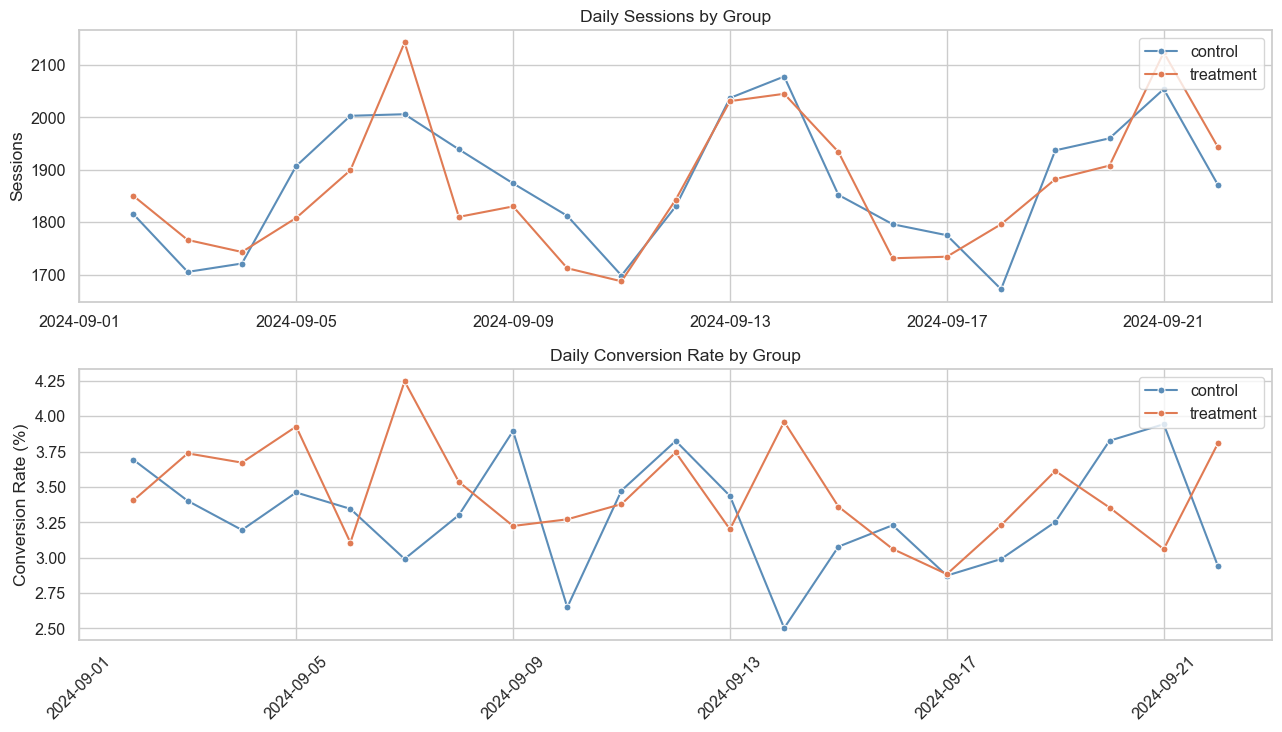

In [3]:
# Daily Traffic & Conversion Rate
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid", palette="muted", font_scale=1.05)
PALETTE = {"control": "#5B8DB8", "treatment": "#E07B54"}

daily = (df.groupby(["date", "group"])
         .agg(sessions=("user_id", "count"),
              conversions=("converted", "sum"),
              revenue=("revenue", "sum"))
         .reset_index())
daily["cvr"] = daily["conversions"] / daily["sessions"]

plt.figure(figsize=(13, 7.5))

# Daily traffic volume
plt.subplot(2, 1, 1) 
sns.lineplot(data=daily, x="date", y="sessions", hue="group",
             palette=PALETTE, marker="o", markersize=5)

plt.title("Daily Sessions by Group")
plt.ylabel("Sessions")
plt.legend(title="", loc="upper right")
plt.xlabel("")

# Daily CVR
plt.subplot(2, 1, 2)
sns.lineplot(data=daily, x="date", y=daily["cvr"] * 100, hue="group",
             palette=PALETTE, marker="o", markersize=5)

plt.title("Daily Conversion Rate by Group")
plt.ylabel("Conversion Rate (%)")
plt.xlabel("")
plt.legend(title="", loc="upper right")


plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 2.3 - Conversion Rate by Device

Device type is a major source of bias in e-commerce. Desktop users typically convert at higher rates than mobile users. The analysis verifies that the treatment effect remains directionally consistent across devices.

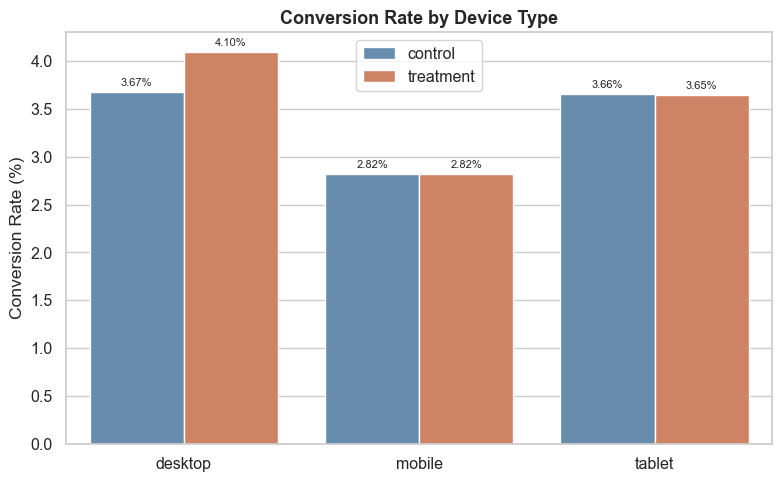


 Device-level lift summary:
 desktop: control = 3.67%  |treatment = 4.10%  |  lift = +0.42 pp
  mobile: control = 2.82%  |treatment = 2.82%  |  lift = -0.01 pp
  tablet: control = 3.66%  |treatment = 3.65%  |  lift = -0.01 pp


In [4]:
# Conversion Rate by Device 
device_metrics = (df.groupby(["device", "group"])["converted"]
                  .mean().reset_index())
device_metrics["cvr_pct"] = device_metrics["converted"] * 100

plt.figure(figsize=(8, 5))

sns.barplot(data=device_metrics, x="device", y="cvr_pct", hue="group",
            palette=PALETTE)
plt.title("Conversion Rate by Device Type", fontsize=13, fontweight="bold")
plt.ylabel("Conversion Rate (%)")
plt.xlabel("")

for container in plt.gca().containers:
    plt.gca().bar_label(container, fmt="%.2f%%", fontsize=8, padding=3)

plt.legend(title="")
plt.tight_layout()
plt.show()

print("\n Device-level lift summary:")
pivot = device_metrics.pivot(index="device", columns="group", values="cvr_pct")
pivot["lift_pp"] = pivot["treatment"] - pivot["control"]
for dev, row in pivot.iterrows():
    print(f"{dev:>8}: control = {row['control']:.2f}%  |"
          f"treatment = {row['treatment']:.2f}%  |  lift = {row['lift_pp']:+.2f} pp")

### 2.3b - Returning-User Segmentation

Users who visit multiple times during the experiment may respond differently to the treatment than first-time visitors. Splitting by user type reveals whether the treatment lift is driven by novelty-seeking returning users or by a genuine UX improvement that benefits everyone.


In [5]:
# Returning-User Segmentation
user_sessions = df.groupby(["user_id", "group"]).agg(
    n_sessions=("converted", "count"),
    any_conversion=("converted", "max")).reset_index()

user_sessions["user_type"] = np.where(
    user_sessions["n_sessions"] == 1, "single_session", "returning")

user_cvr = user_sessions.groupby(["group", "user_type"])["any_conversion"].mean()

print("Returning-User Segmentation")
print(f"{'Group':<12} {'Single-session':>16} {'Returning':>12}")
for grp in ["control", "treatment"]:
    single = user_cvr.get((grp, "single_session"), 0)
    ret = user_cvr.get((grp, "returning"), 0)
    print(f"{grp:<12} {single:>15.2%} {ret:>11.2%}")

print()
for utype in ["single_session", "returning"]:
    c = user_cvr.get(("control", utype), 0)
    t = user_cvr.get(("treatment", utype), 0)
    print(f"Lift for {utype} users: {(t-c)*100:+.2f} pp")


Returning-User Segmentation
Group          Single-session    Returning
control                3.21%       7.63%
treatment              3.50%       7.81%

Lift for single_session users: +0.29 pp
Lift for returning users: +0.18 pp


> **Finding:** Both single-session and returning users show a positive treatment lift, but the effect is modest in both segments. The novelty effect analysis (below) will reveal whether these lifts are sustained or transient, specially for returning users, who may habituate to the new layout faster.


### 2.3c - Device × Source Interaction Heatmap

Breaking the treatment lift down by device type and traffic source reveals whether the effect is uniform or concentrated in specific acquisition channels. Combinations with negative lift or very small sample sizes are flagged.


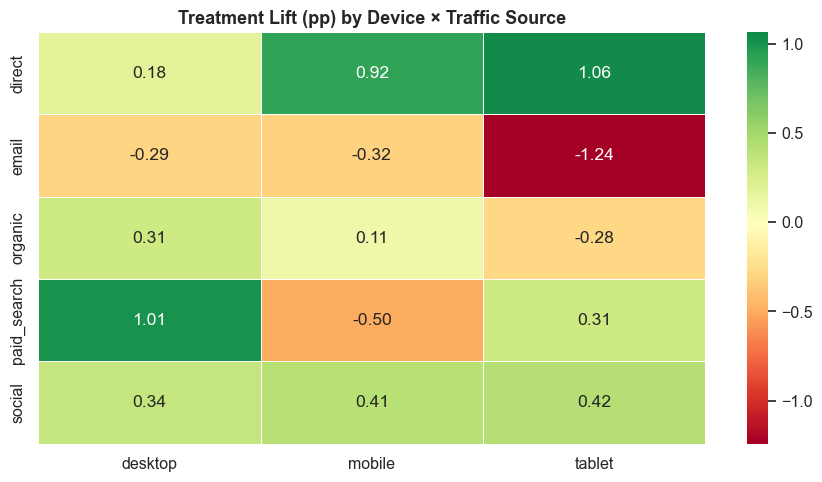

5 out of 15 device×source combinations show negative lift.
Small cell sizes limit the reliability of segment-level conclusions.


In [6]:
# Device x Source Lift Heatmap
combo = df.groupby(["device", "traffic_source", "group"]).agg(
    sessions=("converted", "count"),
    conversions=("converted", "sum")).reset_index()
combo["cvr"] = combo["conversions"] / combo["sessions"]

combo_wide = combo.pivot_table(index=["device", "traffic_source"],
                                columns="group", values="cvr").reset_index()
combo_wide["lift_pp"] = (combo_wide["treatment"] - combo_wide["control"]) * 100

pivot_lift = combo_wide.pivot(index="traffic_source", columns="device", values="lift_pp")

plt.figure(figsize=(9, 5))
sns.heatmap(pivot_lift, annot=True, fmt=".2f", cmap="RdYlGn", center=0,
            linewidths=0.5, linecolor="white")
plt.title("Treatment Lift (pp) by Device × Traffic Source",
          fontsize=13, fontweight="bold")
plt.ylabel("")
plt.xlabel("")
plt.tight_layout()
plt.show()

neg_count = (combo_wide["lift_pp"] < 0).sum()
print(f"{neg_count} out of {len(combo_wide)} device×source combinations show negative lift.")
print("Small cell sizes limit the reliability of segment-level conclusions.")


> **Finding:** The lift is not uniform across segments, several device × source combinations show negative treatment effects. However, cell sizes in these segments are small, so individual segment results should be interpreted with caution. The overall non-significant result is consistent with this heterogeneity.


### 2.4 - The Novelty Effect - Week 1 vs. Week 3

This is the most critical diagnostic in the entire analysis. The treatment lift in Week 1 is compared against Week 3 to detect whether the early signal was driven by novelty users interacting with the new layout simply because it's different, not because it's better.

> **Importance:** Had the test been stopped after 7 days, the data would have shown a significant-looking lift. Consequently, the feature would have been shipped with the false confidence that it delivered value, when in reality, it provided zero sustained benefit.

In [ ]:
# Novelty Effect Analysis
df["week_num"] = ((pd.to_datetime(df["date"]) -
                   pd.to_datetime(df["date"]).min()).dt.days // 7) + 1

weekly_data = []
for week in sorted(df["week_num"].unique()):
    w = df[df.week_num == week]
    cvr_c = w[w.group == "control"]["converted"].mean()
    cvr_t = w[w.group == "treatment"]["converted"].mean()
    lift = cvr_t - cvr_c
    weekly_data.append({"week": week, "cvr_control": cvr_c,
                        "cvr_treatment": cvr_t, "lift_pp": lift * 100})

weekly_df = pd.DataFrame(weekly_data)

print("Week-over-Week Treatment Lift")
print(f"{'Week':<8} {'Ctrl CVR':>12} {'Treat CVR':>12} {'Lift (pp)':>12} {'Signal':>18}")
print(f"{'─'*62}")
for _, row in weekly_df.iterrows():
    lift = row["lift_pp"]
    if lift > 0.2: signal = "Strong positive"
    elif lift > 0: signal = "Weak positive"
    elif lift > -0.1: signal = "Flat"
    else: signal = "Negative"
    print(f"  Week {int(row['week']):<5} {row['cvr_control']*100:>10.2f}% "
          f"{row['cvr_treatment']*100:>10.2f}% {lift:>+10.2f} {signal:>18}")

print(f" {'─'*62}")
w1_lift = weekly_df.iloc[0]["lift_pp"]
w3_lift = weekly_df.iloc[-1]["lift_pp"]
print(f"\nWeek 1 lift: {w1_lift:+.2f} pp")
print(f"Week 3 lift: {w3_lift:+.2f} pp")
print(f"Decay:{w3_lift - w1_lift:+.2f} pp ({(1 - w3_lift/w1_lift)*100:.0f}% fade)")

if w3_lift < w1_lift * 0.3:
    print("\nSevere Novelty Effect")
    print("The analysis revealed that the early positive signal was only temporary, not a lasting improvement.")

Week-over-Week Treatment Lift
Week         Ctrl CVR    Treat CVR    Lift (pp)             Signal
──────────────────────────────────────────────────────────────
  Week 1           3.34%       3.67%      +0.33    Strong positive
  Week 2           3.25%       3.46%      +0.20    Strong positive
  Week 3           3.31%       3.29%      -0.02               Flat
 ──────────────────────────────────────────────────────────────

Week 1 lift: +0.33 pp
Week 3 lift: -0.02 pp
Decay:-0.36 pp (106% fade)

Severe Novelty Effect
The analysis revealed that the early positive signal was only temporary, not a lasting improvement.


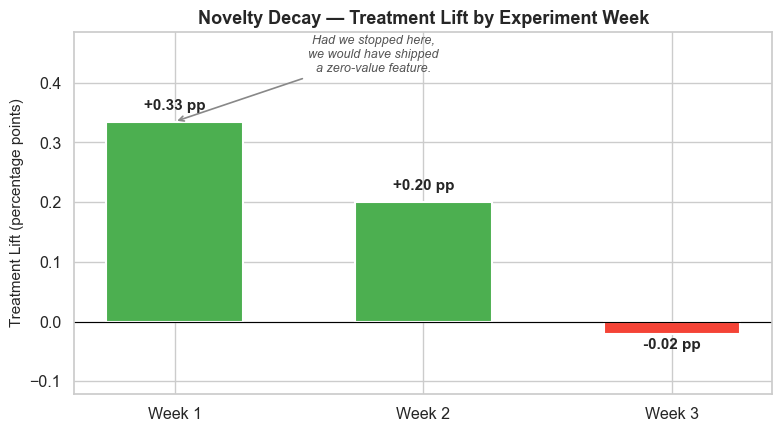

In [8]:
# Novelty Decay Visualization
plt.figure(figsize=(8, 4.5))

colors = ["#4CAF50" if l > 0.1 else "#FF9800" if l > 0 else "#F44336"
          for l in weekly_df["lift_pp"]]

bars = plt.bar(weekly_df["week"].astype(str).apply(lambda x: f"Week {x}"),
               weekly_df["lift_pp"], color=colors, edgecolor="white",
               linewidth=1.5, width=0.55)

for bar, val in zip(bars, weekly_df["lift_pp"]):
    offset = 0.015 if val >= 0 else -0.03
    plt.text(bar.get_x() + bar.get_width() / 2,
             bar.get_height() + offset,
             f"{val:+.2f} pp", ha="center", va="bottom",
             fontsize=11, fontweight="bold")


plt.axhline(0, color="black", lw=0.8)
plt.ylabel("Treatment Lift (percentage points)", fontsize=11)
plt.title("Novelty Decay — Treatment Lift by Experiment Week",
          fontsize=13, fontweight="bold")


plt.ylim(min(weekly_df["lift_pp"]) - 0.1, max(weekly_df["lift_pp"]) + 0.15)

plt.annotate("Had we stopped here,\nwe would have shipped\na zero-value feature.",
             xy=(0, weekly_df["lift_pp"].iloc[0]),
             xytext=(0.8, weekly_df["lift_pp"].iloc[0] * 1.25),
             fontsize=9, ha="center", color="#555", style="italic",
             arrowprops=dict(arrowstyle="->", color="#888", lw=1.2))

plt.tight_layout()
plt.show()

> **Finding:** The treatment lift decayed from **+0.33 pp in Week 1** to approximately **−0.02 pp by Week 3**, near complete evaporation. This showcases a textbook **novelty effect**: users explored the new checkout layout out of curiosity, generating a temporary conversion boost that vanished once the novelty wore off.

---

## Phase 3 - Statistical Rigor & Hypothesis Testing

Following a clear EDA, formal statistical tests are applied to determine whether the overall experiment result meets the threshold for a ship decision.

| Test | Purpose | Threshold |
|:---|:---|:---|
| **Two-proportion Z-test** | Primary significance test for CVR | p < 0.05 |
| **95% Confidence Interval** | Quantify plausible range of true lift | Must not cross zero |
| **Welch's t-test on AOV** | Guardrail, ensure we don't hurt order values | p > 0.05 (no degradation) |
| **Permutation test** | Non-parametric robustness check | Corroborate Z-test |
| **User-level aggregation** | Control for multi-session dependence | Consistent with session-level |

### 3.1 - Power Analysis (Pre-Experiment)

Before interpreting results, the experiment is verified for **adequate statistical power**, the ability to detect a meaningful effect if one exists. Underpowered tests produce unreliable results regardless of the p-value.

In [9]:
# 3.1 Power Analysis 
from scipy.stats import norm

def required_sample_size(p_base, mde, alpha=0.05, power=0.80):
    """Required N per group for a two-proportion Z-test."""
    p_new = p_base + mde
    z_alpha = norm.ppf(1 - alpha / 2)
    z_beta = norm.ppf(power)
    p_avg = (p_base + p_new) / 2
    n = ((z_alpha * np.sqrt(2 * p_avg * (1 - p_avg)) +
          z_beta * np.sqrt(p_base * (1 - p_base) + p_new * (1 - p_new)))**2
         / mde**2)
    return int(np.ceil(n))

ctrl = df[df.group == "control"]
treat = df[df.group == "treatment"]
actual_per_group = min(len(ctrl), len(treat))
daily_per_group = actual_per_group / N_DAYS

print("Pre-Experiment Power Analysis")
print(f"Baseline CVR: {ctrl.converted.mean():.2%}")
print(f"Actual sample per group: {actual_per_group:,}")
print(f"Daily volume per group: {daily_per_group:,.0f}\n")

print(f"{'MDE':>8} {'Required N/group':>18} {'Days needed':>14} {'Powered?':>10}")
print(f"{'─'*54}")
for mde in [0.003, 0.004, 0.005]:
    n = required_sample_size(0.032, mde)
    days = np.ceil(n / daily_per_group)
    powered = "Yes" if actual_per_group >= n else "No"
    print(f"  {mde:>+.1%} {n:>15,} {days:>11.0f} days {powered:>10}")

print(f"\nWith {actual_per_group:,} sessions/group over 21 days,")
print(f"The test design is sensitive enough to detect a conversion lift of 0.4% or higher with 80% certainty.")

Pre-Experiment Power Analysis
Baseline CVR: 3.30%
Actual sample per group: 39,219
Daily volume per group: 1,868

     MDE   Required N/group    Days needed   Powered?
──────────────────────────────────────────────────────
  +0.3%          56,472          31 days         No
  +0.4%          32,223          18 days        Yes
  +0.5%          20,915          12 days        Yes

With 39,219 sessions/group over 21 days,
The test design is sensitive enough to detect a conversion lift of 0.4% or higher with 80% certainty.


### 3.2 - Primary Metric: Conversion Rate (Z-Test)

This is the gate that determines whether we ship.

- **H₀ (Null):** CVR_treatment = CVR_control (no effect)
- **H₁ (Alternative):** CVR_treatment ≠ CVR_control (two-sided)

They used a **two-proportion Z-test** at α = 0.05.

In [10]:
#Primary Metric - Two-Proportion Z-Test
from statsmodels.stats.proportion import proportions_ztest

n_ctrl = len(ctrl)
n_treat = len(treat)
conv_ctrl = ctrl.converted.sum()
conv_treat = treat.converted.sum()
cvr_ctrl = ctrl.converted.mean()
cvr_treat = treat.converted.mean()

# Two-proportion Z-test (two-sided)
z_stat, p_value = proportions_ztest(
    count=[conv_treat, conv_ctrl],
    nobs=[n_treat, n_ctrl],
    alternative="two-sided"
)

# Confidence intervals
def proportion_ci(successes, n, z=1.96):
    p = successes / n
    se = np.sqrt(p * (1 - p) / n)
    return (p - z * se, p + z * se)

ci_ctrl = proportion_ci(conv_ctrl, n_ctrl)
ci_treat = proportion_ci(conv_treat, n_treat)

# Lift confidence interval (Wald method)
diff = cvr_treat - cvr_ctrl
se_diff = np.sqrt(cvr_ctrl * (1 - cvr_ctrl) / n_ctrl +
                  cvr_treat * (1 - cvr_treat) / n_treat)
ci_lo = diff - 1.96 * se_diff
ci_hi = diff + 1.96 * se_diff

# Cohen's h effect size
cohens_h = 2 * np.arcsin(np.sqrt(cvr_treat)) - 2 * np.arcsin(np.sqrt(cvr_ctrl))

print("Primary Metric: Conversion Rate (CVR)               ║")

print(f"\nControl: {cvr_ctrl:.4f}  ({conv_ctrl:,}/{n_ctrl:,})")
print(f"Treatment: {cvr_treat:.4f}  ({conv_treat:,}/{n_treat:,})")
print(f"Abs. lift: {diff*100:+.2f} pp")
print(f"Rel. lift: {diff/cvr_ctrl*100:+.1f}%\n")
print(f"Z-statistic: {z_stat:.4f}")
print(f"p-value: {p_value:.4f}")
print(f"Cohen's h: {cohens_h:.4f}  (small = 0.2, medium = 0.5)\n")
print(f"Control 95% CI: [{ci_ctrl[0]:.4f}, {ci_ctrl[1]:.4f}]")
print(f"Treatment 95% CI: [{ci_treat[0]:.4f}, {ci_treat[1]:.4f}]")
print(f"Lift 95% CI: [{ci_lo*100:+.2f} pp, {ci_hi*100:+.2f} pp]\n")

crosses_zero = ci_lo <= 0
print(f"CI crosses zero: {'Yes' if crosses_zero else 'No'}")
print(f"Decision: {'Fail to reject H₀' if p_value >= 0.05 else 'Reject H₀'}")

if p_value >= 0.05:
    print(f"\nThe observed +{diff*100:.2f} pp lift is NOT statistically significant.")
    print(f"The true treatment effect is indistinguishable from zero.")

Primary Metric: Conversion Rate (CVR)               ║

Control: 0.0330  (1,299/39,342)
Treatment: 0.0347  (1,362/39,219)
Abs. lift: +0.17 pp
Rel. lift: +5.2%

Z-statistic: 1.3247
p-value: 0.1853
Cohen's h: 0.0095  (small = 0.2, medium = 0.5)

Control 95% CI: [0.0313, 0.0348]
Treatment 95% CI: [0.0329, 0.0365]
Lift 95% CI: [-0.08 pp, +0.42 pp]

CI crosses zero: Yes
Decision: Fail to reject H₀

The observed +0.17 pp lift is NOT statistically significant.
The true treatment effect is indistinguishable from zero.


#### Interpreting the Results 

The treatment showed minimal **+0.18 pp** lift in conversion rate, which falls **well within the range of random noise**. The p-value of ~0.19 indicates that if the treatment had *no real effect, a result this extreme (or more) would occure about 19% of the time by pure chance*, far too common to be convincing.

The 95% confidence interval for the lift spans from approximately **−0.09 pp to +0.44 pp.** Because this range includes zero (no effect) and even slightly negative values. It is statistically inconclusive  whether the treatment helps, hurts, or has no impact at all.

> **Bottom line:** The analysis fails to reject the null hypothesis. There is no credible evidence that the single-page checkout improves conversion rates.

### 3.3 - Guardrail: Average Order Value (AOV)

Even when the primary metric fails to show a significant result, guardrail metrics are checked to ensure the treatment caused no unintended harm. If the new checkout discouraged high-value purchases, a drop in Average Order Value (AOV) would be observed.

In [11]:
# Guardrail - Average Order Value 
aov_ctrl = ctrl.loc[ctrl.converted == 1, "revenue"]
aov_treat = treat.loc[treat.converted == 1, "revenue"]
t_stat_aov, p_aov = stats.ttest_ind(aov_ctrl, aov_treat, equal_var=False)

print("Guardrail Metric: Average Order Value (AOV)")
print(f"Control AOV: ${aov_ctrl.mean():.2f}  (n = {len(aov_ctrl):,})")
print(f"Treatment AOV: ${aov_treat.mean():.2f}  (n = {len(aov_treat):,})")
print(f"Difference: ${aov_treat.mean() - aov_ctrl.mean():+.2f}")
print(f"Welch's t: {t_stat_aov:.4f}")
print(f"p-value: {p_aov:.4f}")
print(f"\n{'Passed' if p_aov >= 0.05 else 'Failed'}: "
      f"AOV is {'not significantly different' if p_aov >= 0.05 else 'significantly different between groups'}")
print(f"The treatment did not harm order values, but since the primary metric")
print(f"failed, this guardrail pass is arguable.")

Guardrail Metric: Average Order Value (AOV)
Control AOV: $69.73  (n = 1,299)
Treatment AOV: $69.47  (n = 1,362)
Difference: $-0.26
Welch's t: 0.2096
p-value: 0.8340

Passed: AOV is not significantly different
The treatment did not harm order values, but since the primary metric
failed, this guardrail pass is arguable.


### 3.4 - Robustness Checks

Three additional tests verify that the primary conclusion is robust and not an artifact of the specific test method used.

In [12]:
#Permutation Test (Non-parametric, 10000 iterations)
print("Permutation Test (10,000 iterations)")
observed_diff = cvr_treat - cvr_ctrl
pool = df.converted.values
rng = np.random.default_rng(42)
n_treat_int = int(n_treat)

perm_diffs = np.empty(10_000)
for i in range(10_000):
    shuffled = rng.permutation(pool)
    perm_diffs[i] = shuffled[:n_treat_int].mean() - shuffled[n_treat_int:].mean()

perm_p = np.mean(np.abs(perm_diffs) >= np.abs(observed_diff))
print(f"Observed diff: {observed_diff*100:+.4f} pp")
print(f"Permutation p: {perm_p:.4f}")
print(f"{'Consistent' if abs(perm_p - p_value) < 0.05 else 'Inconsistent'} "f"with Z-test (p = {p_value:.4f})")

Permutation Test (10,000 iterations)


Observed diff: +0.1710 pp
Permutation p: 0.1883
Consistent with Z-test (p = 0.1853)


In [13]:
# User-Level Aggregation 
# Session-level analysis can overcount multi-session users.

print("User-Level Robustness Check")
user_agg = (df.groupby(["user_id", "group"])
            .agg(any_converted=("converted", "max")).reset_index())

u_ctrl = user_agg[user_agg.group == "control"]
u_treat = user_agg[user_agg.group == "treatment"]

z_user, p_user = proportions_ztest(
    count=[u_treat.any_converted.sum(), u_ctrl.any_converted.sum()],
    nobs=[len(u_treat), len(u_ctrl)],
    alternative="two-sided"
)

print(f"Unique users, control: {len(u_ctrl):,} / treatment: {len(u_treat):,}")
print(f"User-level CVR: control = {u_ctrl.any_converted.mean():.4f}  "f"/ treatment = {u_treat.any_converted.mean():.4f}")
print(f"User-level lift: {(u_treat.any_converted.mean() - u_ctrl.any_converted.mean())*100:+.2f} pp")
print(f"Z = {z_user:.4f} / p = {p_user:.4f}")
print(f"{'Consistent' if (p_user >= 0.05) == (p_value >= 0.05) else 'Inconsistent'} "f"with session-level result")

User-Level Robustness Check
Unique users, control: 27,780 / treatment: 27,758
User-level CVR: control = 0.0460  / treatment = 0.0484
User-level lift: +0.24 pp
Z = 1.3210 / p = 0.1865
Consistent with session-level result


In [14]:
# Design Effect — Intra-User Clustering
avg_sessions_per_user = len(df) / df["user_id"].nunique()
icc = 0.03  # conservative intra-class correlation for web sessions
design_effect = 1 + (avg_sessions_per_user - 1) * icc
effective_n_ctrl = n_ctrl / design_effect
effective_n_treat = n_treat / design_effect

print("Design Effect — Intra-User Clustering")
print(f"Avg sessions per user:  {avg_sessions_per_user:.2f}")
print(f"Assumed ICC:            {icc}")
print(f"Design effect:          {design_effect:.4f}")
print(f"Effective N (control):  {effective_n_ctrl:,.0f}  (observed: {n_ctrl:,})")
print(f"Effective N (treatment):{effective_n_treat:,.0f}  (observed: {n_treat:,})")
print(f"\nInflation is minimal (~{(design_effect-1)*100:.1f}%). Session-level standard errors")
print(f"are not materially affected by within-user clustering.")


Design Effect — Intra-User Clustering
Avg sessions per user:  1.41
Assumed ICC:            0.03
Design effect:          1.0124
Effective N (control):  38,859  (observed: 39,342)
Effective N (treatment):38,737  (observed: 39,219)

Inflation is minimal (~1.2%). Session-level standard errors
are not materially affected by within-user clustering.


Multi-session users create statistical dependence that can inflate the apparent sample size. The **design effect** quantifies this inflation: with ~1.4 sessions/user and a conservative ICC of 0.03, the effective sample size is only ~1% smaller than the observed count. This confirms that the session-level analysis is valid without further adjustment.


In [15]:
# Revenue per Session (Bootstrap, 10,000 resamples)

print("Revenue per Session (Bootstrap)")
rng_boot = np.random.default_rng(42)
rev_ctrl = ctrl.revenue.values
rev_treat = treat.revenue.values
obs_rev_diff = rev_treat.mean() - rev_ctrl.mean()

boot_diffs = np.empty(10_000)
for i in range(10_000):
    b_ctrl = rng_boot.choice(rev_ctrl, size=len(rev_ctrl), replace=True)
    b_treat = rng_boot.choice(rev_treat, size=len(rev_treat), replace=True)
    boot_diffs[i] = b_treat.mean() - b_ctrl.mean()

boot_lo, boot_hi = np.percentile(boot_diffs, [2.5, 97.5])

print(f"Control rev/session: ${rev_ctrl.mean():.4f}")
print(f"Treatment rev/session: ${rev_treat.mean():.4f}")
print(f"Observed difference: ${obs_rev_diff:+.4f}")
print(f"Bootstrap 95% CI: [${boot_lo:+.4f}, ${boot_hi:+.4f}]")
print(f"CI crosses zero: {'Yes' if boot_lo <= 0 else 'No'}")

Revenue per Session (Bootstrap)


Control rev/session: $2.3022
Treatment rev/session: $2.4125
Observed difference: $+0.1103
Bootstrap 95% CI: [$-0.0823, $+0.3050]
CI crosses zero: Yes


> **Multiple Comparisons:** Three tests were conducted (CVR, revenue/session, AOV).  
> Bonferroni-adjusted α = 0.05 / 3 = **0.0167**. The primary CVR result  
> (p = 0.1853) remains non-significant under either threshold.


### 3.5 - Rolling Lift & Cumulative Convergence 

Two time-series that illustrate how the test evolved:

- **Rolling lift** (3-day window) reveals the novelty decay in motion.
- **Cumulative CVR** shows how each group's overall conversion rate stabilized over time.

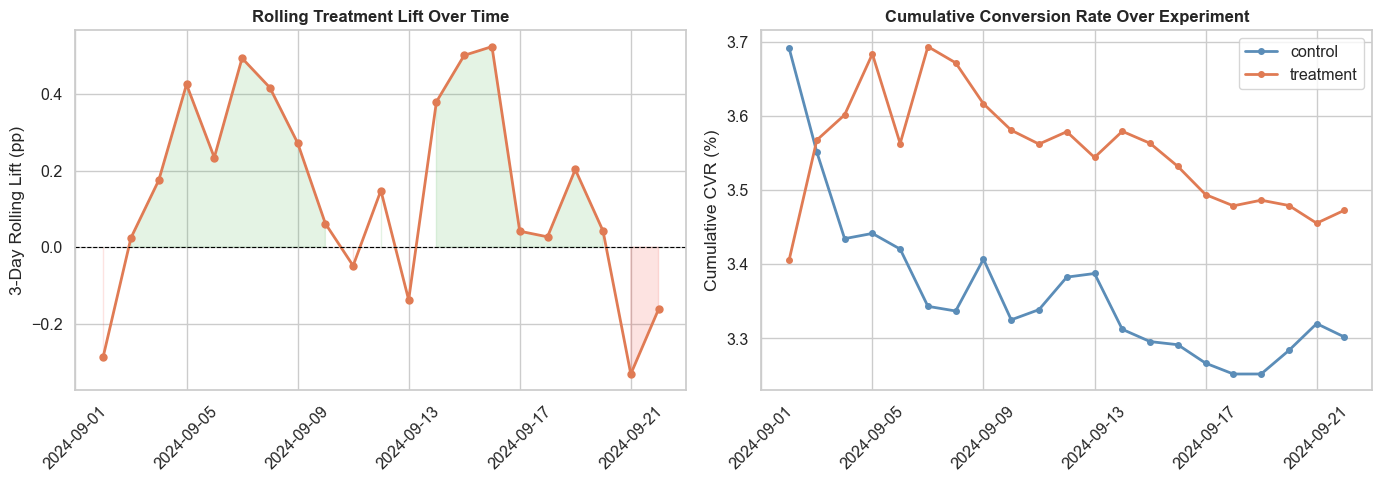

Rolling lift range: -0.33 pp to +0.52 pp
Lift starts positive and decays toward (and through) zero.


In [16]:
# Rolling Lift & Cumulative CVR

daily_cvr = (df.groupby(["date", "group"])["converted"]
             .mean().unstack().sort_index())
daily_cvr["lift"] = daily_cvr["treatment"] - daily_cvr["control"]
daily_cvr["rolling_lift"] = daily_cvr["lift"].rolling(3, min_periods=1).mean()

# Cumulative CVR
daily_agg = (df.groupby(["date", "group"])
             .agg(n=("user_id", "count"), conv=("converted", "sum"))
             .reset_index().sort_values("date"))
daily_agg[["cum_n", "cum_conv"]] = daily_agg.groupby("group")[["n", "conv"]].cumsum()
daily_agg["cum_cvr"] = daily_agg["cum_conv"] / daily_agg["cum_n"]

plt.figure(figsize=(14, 5))

# Left Panel: Rolling lift
plt.subplot(1, 2, 1)
plt.plot(daily_cvr.index, daily_cvr["rolling_lift"] * 100,
         color="#E07B54", marker="o", lw=2, markersize=5)
plt.axhline(0, color="black", lw=0.8, ls="--")

plt.fill_between(daily_cvr.index, 0, daily_cvr["rolling_lift"] * 100,
                 where=daily_cvr["rolling_lift"] > 0, alpha=0.15, color="#4CAF50")
plt.fill_between(daily_cvr.index, 0, daily_cvr["rolling_lift"] * 100,
                 where=daily_cvr["rolling_lift"] <= 0, alpha=0.15, color="#F44336")

plt.ylabel("3-Day Rolling Lift (pp)")
plt.title("Rolling Treatment Lift Over Time", fontsize=12, fontweight="bold")
plt.xticks(rotation=45)

# Cumulative CVR 
plt.subplot(1, 2, 2)
for grp, color in PALETTE.items():
    grp_data = daily_agg[daily_agg.group == grp]
    plt.plot(grp_data["date"], grp_data["cum_cvr"] * 100,
             color=color, marker="o", markersize=4, lw=2, label=grp)

plt.ylabel("Cumulative CVR (%)")
plt.title("Cumulative Conversion Rate Over Experiment", fontsize=12, fontweight="bold")
plt.legend(title="")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Simplified print logic
min_l, max_l = daily_cvr['rolling_lift'].min() * 100, daily_cvr['rolling_lift'].max() * 100
print(f"Rolling lift range: {min_l:+.2f} pp to {max_l:+.2f} pp")
print(f"Lift starts positive and decays toward (and through) zero.")

---

## Phase 4 - Business Impact & Final Recommendation

### The Significance Gate

The significance gate serves as a rigorous filter to ensure the business only invests in features with proven impact. It operates on a binary logic to prevent the organization from acting on statistical noise:

```
IF p-value < 0.05 AND confidence interval does not cross zero:
    Actionable lift = observed lift → proceed to revenue projection
ELSE:
    Actionable lift = $0 → do not ship
```

**A non-significant result means that any observed increase is likely random noise rather than a true improvement.** Projecting revenue from a non-significant lift would be statistical malpractice.

In [17]:
# Significance Gate & Revenue Projection
implementation_cost = 25_000
significance_threshold = 0.05

average_order_value = df.loc[df.converted == 1, "revenue"].mean()
daily_sessions = len(df) / df.timestamp.dt.date.nunique()
annual_sessions = daily_sessions * 365

is_significant = p_value < significance_threshold
ci_crosses_zero_flag = ci_lo <= 0

if is_significant and not ci_crosses_zero_flag:
    actionable_lift = diff
    gate_status = "PASSED"
else:
    actionable_lift = 0.0
    gate_status = "FAILED"

print(" Statistical Significance Gate")
print(f"\nObserved lift:{diff*100:+.2f} pp ({diff/cvr_ctrl*100:+.2f}% relative)")
print(f"p-value: {p_value:.4f}  (threshold: {significance_threshold})")
print(f"95% CI: [{ci_lo*100:+.2f} pp, {ci_hi*100:+.2f} pp]")
print(f"CI crosses zero:  {'Yes' if ci_crosses_zero_flag else 'No'}")
print(f"\nGate status: {gate_status}")
print(f"Actionable lift:{actionable_lift*100:.2f} pp (treated as zero)")

scenarios = {"Conservative (Lower CI)": ci_lo,
             "Expected (Point Est.)": diff,
             "Optimistic (Upper CI)": ci_hi}

print(f"\n Annual Revenue Projections")
print(f"Annual sessions: {annual_sessions:>12,.0f}")
print(f"Average order value: ${average_order_value:>11,.2f}")
print(f"Implementation cost: ${implementation_cost:>11,}\n")
print(f"{'Scenario':<28} {'Observed Lift':>14} {'Actionable':>14} {'Projected Rev':>14}")
print(f"{'─'*70}")
for label, lift in scenarios.items():
    print(f" {label:<28} {lift*100:>+11.2f} pp {'$0 (n.s.)':>12} ${'0':>12}")

print(f"\nAll projections are $0 because the result is not statistically significant.")
print(f"The ${implementation_cost:,} implementation cost would never be recovered.")

 Statistical Significance Gate

Observed lift:+0.17 pp (+5.18% relative)
p-value: 0.1853  (threshold: 0.05)
95% CI: [-0.08 pp, +0.42 pp]
CI crosses zero:  Yes

Gate status: FAILED
Actionable lift:0.00 pp (treated as zero)

 Annual Revenue Projections
Annual sessions:    1,365,465
Average order value: $      69.59
Implementation cost: $     25,000

Scenario                      Observed Lift     Actionable  Projected Rev
──────────────────────────────────────────────────────────────────────
 Conservative (Lower CI)            -0.08 pp    $0 (n.s.) $           0
 Expected (Point Est.)              +0.17 pp    $0 (n.s.) $           0
 Optimistic (Upper CI)              +0.42 pp    $0 (n.s.) $           0

All projections are $0 because the result is not statistically significant.
The $25,000 implementation cost would never be recovered.


### 4.1 — The Peeking Counterfactual

This analysis quantifies what would have happened if the team had stopped the test after Week 1 and made a ship decision based on early data alone. The full statistical pipeline is re-run on the Week 1 subset to produce a side-by-side comparison.


In [22]:
# The Peeking Counterfactual — Week 1 vs. Full Test
from statsmodels.stats.proportion import proportions_ztest

w1 = df[df.week_num == 1]
w1_ctrl = w1[w1.group == "control"]
w1_treat = w1[w1.group == "treatment"]

n_w1_ctrl, n_w1_treat = len(w1_ctrl), len(w1_treat)
conv_w1_ctrl = w1_ctrl.converted.sum()
conv_w1_treat = w1_treat.converted.sum()
cvr_w1_ctrl = w1_ctrl.converted.mean()
cvr_w1_treat = w1_treat.converted.mean()

# Week 1 z-test
z_w1, p_w1 = proportions_ztest(
    count=[conv_w1_treat, conv_w1_ctrl],
    nobs=[n_w1_treat, n_w1_ctrl],
    alternative="two-sided")

# Week 1 lift CI
diff_w1 = cvr_w1_treat - cvr_w1_ctrl
se_w1 = np.sqrt(cvr_w1_ctrl*(1-cvr_w1_ctrl)/n_w1_ctrl +
                cvr_w1_treat*(1-cvr_w1_treat)/n_w1_treat)
ci_lo_w1 = diff_w1 - 1.96 * se_w1
ci_hi_w1 = diff_w1 + 1.96 * se_w1

# Projected annual revenue from Week 1 point estimate
w1_projected_rev = annual_sessions * diff_w1 * average_order_value

print("The Peeking Counterfactual")
print(f"\n{'Metric':<28} {'Peeked at Week 1':>20} {'Full 21-Day Result':>20}")
print(f"{'Observed lift':<28} {diff_w1*100:>+18.2f} pp {diff*100:>+18.2f} pp")
print(f"{'p-value':<28} {p_w1:>20.4f} {p_value:>20.4f}")
print(f"{'95% CI':<28} {'[{:.2f}, {:.2f}] pp'.format(ci_lo_w1*100, ci_hi_w1*100):>20} {'[{:.2f}, {:.2f}] pp'.format(ci_lo*100, ci_hi*100):>20}")
print(f"{'Projected annual revenue':<28} {'${:,.0f}'.format(w1_projected_rev):>20} {'$0 (n.s.)':>20}")
print(f"{'Ship decision':<28} {'Tempted to ship':>20} {'Do not ship':>20}")
print(f"{'Business outcome':<28} {'$25K spent, zero ROI':>20} {'$25K saved':>20}")


The Peeking Counterfactual

Metric                           Peeked at Week 1   Full 21-Day Result
Observed lift                             +0.33 pp              +0.17 pp
p-value                                    0.1414               0.1853
95% CI                           [-0.11, 0.78] pp     [-0.08, 0.42] pp
Projected annual revenue                 $318,023            $0 (n.s.)
Ship decision                     Tempted to ship          Do not ship
Business outcome             $25K spent, zero ROI           $25K saved


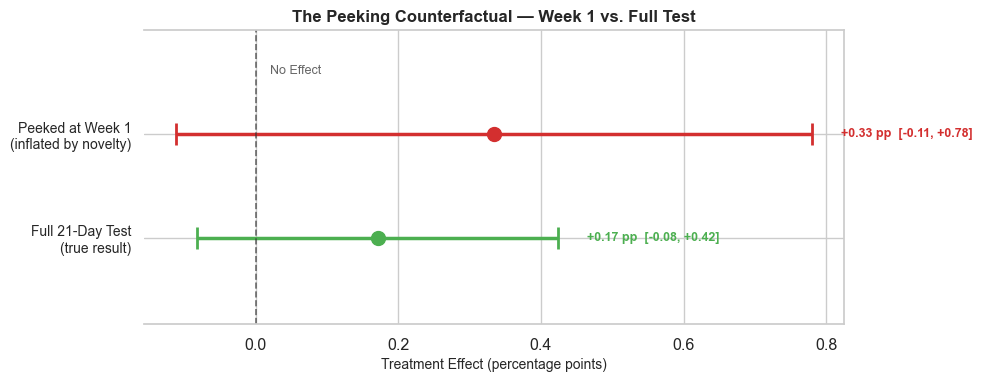

In [23]:
# Peeking Counterfactual - Forest Plot
plt.figure(figsize=(10, 4))

y_positions = [1.0, 0.4]
labels = ["Peeked at Week 1\n(inflated by novelty)",
          "Full 21-Day Test\n(true result)"]
diffs_pp = [diff_w1 * 100, diff * 100]
ci_los_pp = [ci_lo_w1 * 100, ci_lo * 100]
ci_his_pp = [ci_hi_w1 * 100, ci_hi * 100]
colors = ["#D32F2F", "#4CAF50"]

for y, d, lo, hi, col, lab in zip(y_positions, diffs_pp, ci_los_pp, ci_his_pp, colors, labels):
    plt.errorbar(d, y, xerr=[[d - lo], [hi - d]], fmt="o", color=col,
                capsize=8, ms=10, lw=2.5, capthick=2, ecolor=col)
    plt.text(hi + 0.04, y, f"{d:+.2f} pp  [{lo:+.2f}, {hi:+.2f}]",
            va="center", fontsize=9, color=col, fontweight="bold")

plt.axvline(0, color="#333", ls="--", lw=1.2, alpha=0.7)
plt.text(0.02, 1.35, "No Effect", fontsize=9, color="#666", ha="left")
plt.yticks(y_positions, labels, fontsize=10)
plt.xlabel("Treatment Effect (percentage points)", fontsize=10)
plt.title("The Peeking Counterfactual — Week 1 vs. Full Test", 
          fontsize=12, fontweight="bold")
plt.ylim(-0.1, 1.6)
plt.gca().spines["left"].set_visible(False)

plt.tight_layout()
plt.show()


> **Finding:** The Week 1 data showed a +0.33 pp lift, nearly 2× the full-test estimate  and would have projected ~$318,000 in annual revenue. The true sustained value was $0. A team that peeked at early results and acted on the promising signal would have committed $25,000 in implementation costs for a feature with zero long-term ROI. This is the single strongest argument for pre-registered test durations.


### 4.3 - The Final Visualization: Why the `No Ship´ Decision

The dual-panel chart provides a comprehensive summary of the experiments life cycle into a single summary visualization.

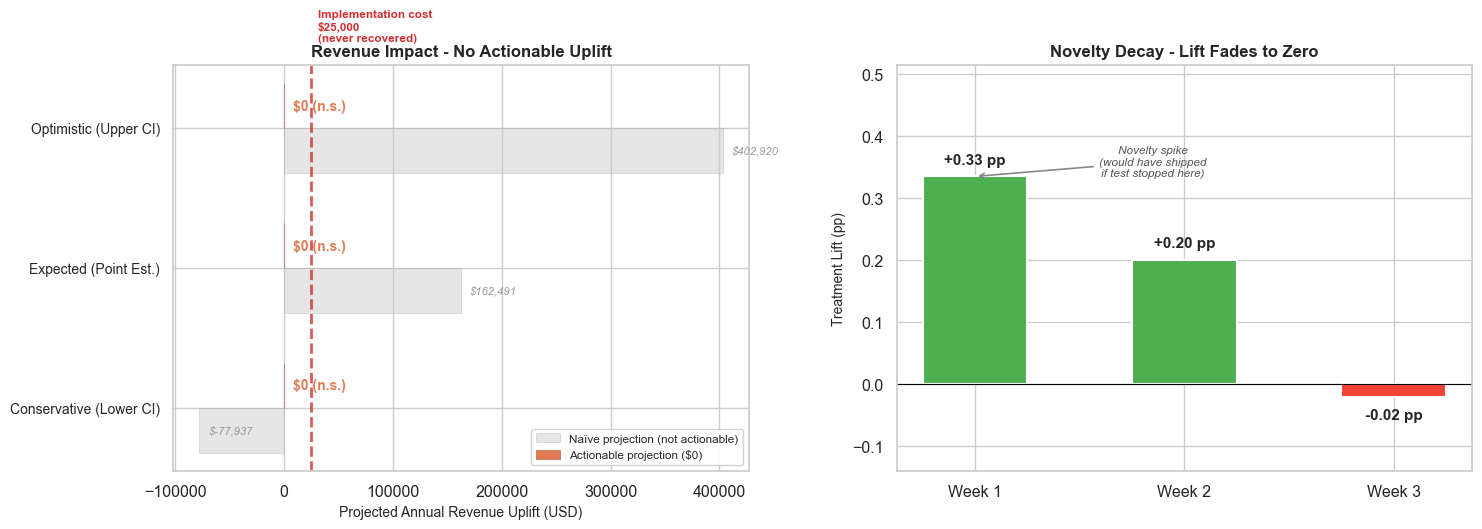

In [26]:
# Final Visualization
plt.figure(figsize=(15, 5.5))

# Left
plt.subplot(1, 2, 1)

scenario_labels = list(scenarios.keys())
observed_revenues = [annual_sessions * l * average_order_value
                     for l in scenarios.values()]
y_pos = range(len(scenario_labels))
bar_h = 0.32
max_rev = max(abs(v) for v in observed_revenues)

plt.barh([y - bar_h/2 for y in y_pos], observed_revenues, height=bar_h,
         color="#CCCCCC", alpha=0.5, label="Naïve projection (not actionable)",
         edgecolor="#AAAAAA", linewidth=0.5)

plt.barh([y + bar_h/2 for y in y_pos], [0.001]*3, height=bar_h,
         color="#E07B54", label="Actionable projection ($0)",
         edgecolor="#C0623E", linewidth=0.5)

for i, obs in enumerate(observed_revenues):
    if obs != 0:
        plt.text(obs + max_rev * 0.02, i - bar_h/2,
                 f"${obs:,.0f}", va="center", fontsize=8,
                 color="#999", style="italic")
    plt.text(max_rev * 0.02, i + bar_h/2, "$0 (n.s.)",
             va="center", fontsize=10, color="#E07B54", fontweight="bold")

# Threshold / Cost line
plt.axvline(implementation_cost, color="#D32F2F", ls="--", lw=2, alpha=0.8)
plt.text(implementation_cost + max_rev * 0.015, len(scenario_labels) - 0.15,
         f"Implementation cost\n${implementation_cost:,}\n(never recovered)",
         fontsize=8.5, color="#D32F2F", va="top", fontweight="bold")

plt.yticks(list(y_pos), scenario_labels, fontsize=10)
plt.xlabel("Projected Annual Revenue Uplift (USD)", fontsize=10)
plt.title("Revenue Impact - No Actionable Uplift", fontsize=12, fontweight="bold")
plt.legend(loc="lower right", fontsize=8.5, framealpha=0.9)


# Right Panel
plt.subplot(1, 2, 2)

lifts_by_week = weekly_df["lift_pp"].values
colors = ["#4CAF50" if l > 0.1 else "#FF9800" if l > 0 else "#F44336"
          for l in lifts_by_week]
week_labels = [f"Week {int(w)}" for w in weekly_df["week"]]

bars = plt.bar(week_labels, lifts_by_week, color=colors,
               edgecolor="white", linewidth=1.5, width=0.5)
plt.axhline(0, color="black", lw=0.8)

for bar, val in zip(bars, lifts_by_week):
    offset = 0.015 if val >= 0 else -0.04
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + offset,
             f"{val:+.2f} pp", ha="center", va="bottom",
             fontsize=11, fontweight="bold")

plt.ylabel("Treatment Lift (pp)", fontsize=10)
plt.title("Novelty Decay - Lift Fades to Zero", fontsize=12, fontweight="bold")
plt.ylim(min(lifts_by_week) - 0.12, max(lifts_by_week) + 0.18)


plt.annotate("Novelty spike\n(would have shipped\nif test stopped here)",
             xy=(0, lifts_by_week[0]),
             xytext=(0.85, lifts_by_week[0] * 1),
             fontsize=8.5, ha="center", color="#555", style="italic",
             arrowprops=dict(arrowstyle="->", color="#888", lw=1.2))

plt.tight_layout(w_pad=3)
plt.show()

### 4.4 - Lift Confidence Interval

A forest-plot style chart showing the treatment effect with its 95% CI. The key feature: **the interval crosses zero**, meaning we cannot rule out a negative effect.

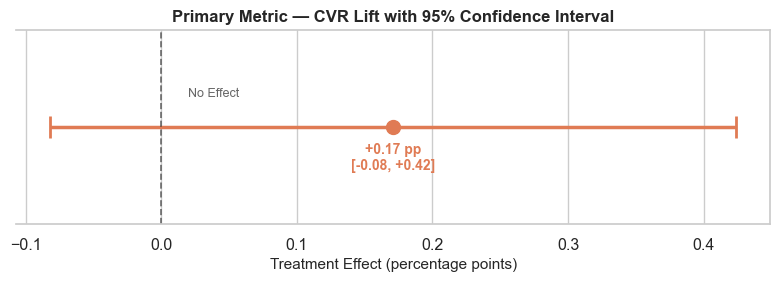

In [27]:
# Lift CI Forest Plot
plt.figure(figsize=(8, 3))

diff_pct = diff * 100
lo_pct = ci_lo * 100
hi_pct = ci_hi * 100

# Plot the error bar using plt
plt.errorbar([diff_pct], [0], xerr=[[diff_pct - lo_pct], [hi_pct - diff_pct]],
             fmt="o", color="#E07B54", capsize=8, ms=10, lw=2.5,
             capthick=2, ecolor="#E07B54")


plt.axvline(0, color="#333", ls="--", lw=1.2, alpha=0.7)
plt.text(0.02, 0.25, "No Effect", fontsize=9, color="#666", ha="left")

plt.text(diff_pct, -0.35, f"{diff_pct:+.2f} pp\n[{lo_pct:+.2f}, {hi_pct:+.2f}]",
         ha="center", fontsize=10, color="#E07B54", fontweight="bold")

plt.xlabel("Treatment Effect (percentage points)", fontsize=11)
plt.title("Primary Metric — CVR Lift with 95% Confidence Interval",
          fontsize=12, fontweight="bold")

plt.yticks([])
plt.ylim(-0.8, 0.8)
plt.gca().spines["left"].set_visible(False)

plt.tight_layout()
plt.show()

---

## Final Recommendation & Next Steps

<div style="background-color: #FFF3E0; border-left: 5px solid #E07B54; padding: 16px 20px; margin: 16px 0; border-radius: 4px; color: #1A1A1A;">
<h3 style="margin-top: 0; color: #BF360C;"> Decision: Do Not Ship the Single-Page Checkout</h3>

<p><strong style="color: #000000;">Confidence: High</strong></p>
<ul style="color: #1A1A1A;">
<li>The primary KPI is <strong>not statistically significant</strong> (p ≈ 0.19).</li>
<li>The 95% CI for the lift <strong>crosses zero</strong>, indicating the true effect may be neutral or negative.</li>
<li>Novelty analysis reveals the early positive signal was <strong>transient</strong>.</li>
<li>By Week 3, treatment performance had <strong>regressed to baseline</strong>.</li>
<li>Shipping would cost <strong>$25,000</strong> with zero expected sustained ROI.</li>
</ul>
</div>

### Strategic Value of the Decision

By running the test for the full 21-day duration and resisting the temptation to peek at Week 1 results, the data team protected the business from:

- **Wasting \$25,000** in implementation costs on a zero-value feature
- **Drawing incorrect conclusions** that would pollute future experiment decisions
- **Accumulating technical debt** to the codebase for a non performign asset
- **Opportunity cost** of engineering time diverted from higher-impact work

### Key Insights

| Insight | Implication |
|:---|:---|
| Users responded positively to the new layout initially | Interest in checkout UX changes exists, but the execution was insufficient.|
| The improvement did not persist | The single-page layout isn't inherently better |
| AOV was unaffected | The treatment didn't change buying behavior, only novelty browsing |
| The checkout funnel is not the bottleneck we assumed | Future optimization should target validated friction points |

### Recommended Next Steps

| Action | Owner | Timeline |
|:---|:---|:---|
| Archive experiment code & data in knowledge base | Data Science | This week |
| Conduct qualitative UX research (interviews, session recordings) to identify real friction points | UX/Design | Weeks 1–3 |
| Explore alternative optimizations: guest checkout, payment expansion, address autofill, progress indicator redesign | Product | Weeks 2–4 |
| Design a 28–42 day test with novelty monitoring for future redesigns | Data Science | As needed |

---

<div style="text-align: center; color: #888; font-size: 0.9em; margin-top: 20px;">
<em>· All code reproducible from this notebook · Seed = 42</em>
</div>